In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import logging
import pathlib
import os
import tempfile
import subprocess
import time 
import json
import shutil
import glob
import concurrent.futures

import pandas as pd
import seaborn
import pydub
from tqdm.notebook import tqdm
import boto3
import webrtcvad
from TTS.utils.audio import AudioProcessor
from TTS.tts.utils.visual import plot_spectrogram
from TTS.config import load_config
from librosa import display
from matplotlib import pylab as plt
import IPython

import barbero_coqui_ai_tts.split_files
from barbero_coqui_ai_tts.wada_snr import wada_snr

tqdm.pandas()
logger = logging.getLogger(__name__)

# Constants

In [24]:
bucket = "barbero-tts2"
region = "eu-central-1"
vocabulary_file = pathlib.Path("vocabulary/vocabulary.txt")
vocabulary_name = "barbero-guerre"
data_local = pathlib.Path("../data")
frame_rate = 16000
max_chunk_duration_seconds = 10
target_normalization_db = -23
config_path = data_local / "generic_config.json"

In [25]:
boto3.setup_default_session(region_name=region)

# Convert original file to wav

In [26]:
lines = pd.read_csv(data_local / "original_files.csv")
lines["from"] = lines["from"].apply(pd.Timedelta)
lines["to"] = lines["to"].apply(pd.Timedelta)
lines

original_audio            from  \
0  /ssd500gb/archivio_barbero/original/7_La_Prima... 0 days 00:01:23   
1  /ssd500gb/archivio_barbero/original/8_Come_sco... 0 days 00:00:00   
2  /ssd500gb/archivio_barbero/original/9_La_Guerr... 0 days 00:00:55   

               to  
0 0 days 01:09:48  
1 0 days 01:07:37  
2 0 days 01:01:36

In [27]:
def convert(row):
    input_file = pathlib.Path(row["original_audio"])
    folder = input_file.parent.parent
    name = input_file.stem
    output_folder = folder / "wav"
    output_name = output_folder / f"{name}.wav"
    output_folder.mkdir(exist_ok=True, parents=True)
    sound = pydub.AudioSegment.from_mp3(input_file)
    sound = sound.set_channels(1)  # save to mono
    # cut the section between from and to
    beginning = 1000 * int(row["from"].total_seconds())
    end = 1000 * int(row["to"].total_seconds())
    sound = sound[beginning:end]
    sound = sound.set_frame_rate(frame_rate)
    sound.export(output_name, format="wav")
    logger.debug("converted %s to %s", input_file, output_name)
    return output_name

In [28]:
lines["wav"] = lines.progress_apply(convert, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

# Normalize

In [29]:
def normalize(row):
    input_file = pathlib.Path(row["wav"])
    folder = input_file.parent.parent
    name = input_file.stem
    output_folder = folder / "normalized_wav"
    output_name = output_folder / f"{name}.wav"
    # stupid business with using a non-ext4 filesystem
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_out_name = pathlib.Path(tmpdirname) / output_name.name
        output_folder.mkdir(exist_ok=True, parents=True)
        command = f"ffmpeg-normalize -f --normalization-type rms --target-level {target_normalization_db} {row['wav']} -o {temp_out_name}"
        subprocess.check_call(command, shell=True)
        command = f"mv {temp_out_name} {output_name}"
        subprocess.check_call(command, shell=True)
    return output_name

In [30]:
lines["normalized_wav"] = lines.progress_apply(normalize, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

# Split wav file into chunks

In [31]:
vad = webrtcvad.Vad(3)

In [32]:
def load_sound(row):
    sound = pydub.AudioSegment.from_file(row["normalized_wav"], format="wav")
    return sound

In [33]:
lines["sound"] = lines.apply(load_sound, axis=1)

In [34]:
def split_row_on_silence(row):
    frame_duration_ms = 30
    chunks = list(barbero_coqui_ai_tts.split_files.vad_collector(
        frame_rate,
        frame_duration_ms, 20 * frame_duration_ms,
        vad,
        row["sound"][::frame_duration_ms],
    ))
    durations = pd.DataFrame(
        {
            "sound": chunks,
            "duration": [chunk.duration_seconds for chunk in chunks],
        }
    )
    durations["normalized_wav"] = row["normalized_wav"]
    return durations

In [35]:
raw_chunks = pd.concat(lines.progress_apply(split_row_on_silence, axis=1).tolist())

  0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
raw_chunks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693 entries, 0 to 497
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sound           1693 non-null   object 
 1   duration        1693 non-null   float64
 2   normalized_wav  1693 non-null   object 
dtypes: float64(1), object(2)
memory usage: 52.9+ KB


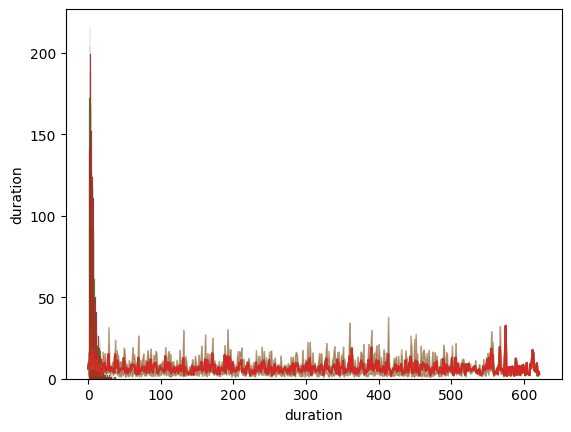

In [55]:
seaborn.lineplot(x=raw_chunks.index, y=raw_chunks.duration)
plt.show()

<Axes: xlabel='duration', ylabel='Count'>

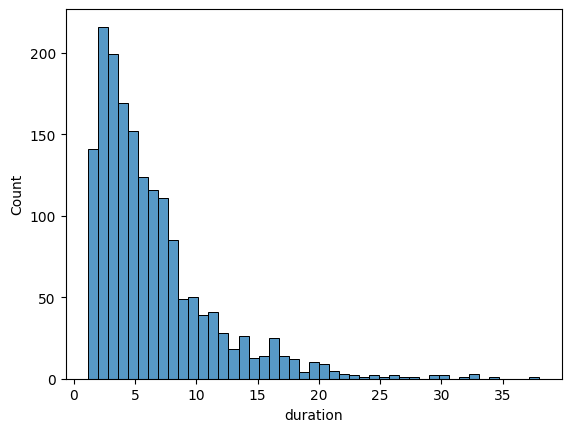

In [56]:
seaborn.histplot(raw_chunks.duration)

# Group up chunks that are too short

In [66]:
def group_chunks(df, min_duration_seconds=2, crossfade=0):
    current_duration = 0
    current_sound = pydub.AudioSegment.empty()
    current_normalized_wav = ""
    for index, row in df.iterrows():
        if not current_normalized_wav:
            # first row
            current_duration += row["duration"]
            current_sound = current_sound.append(row["sound"], crossfade=crossfade)
            current_normalized_wav = row["normalized_wav"]
        elif current_normalized_wav:
            if current_normalized_wav != row["normalized_wav"]:
                # we just changed file so we dont concatenate from different files
                yield {
                    "normalized_wav": current_normalized_wav,
                    "sound": current_sound,
                    "duration": current_duration,
                }
                current_duration = row["duration"]
                current_sound = row["sound"]
                current_normalized_wav = row["normalized_wav"]
            else:
                # we are within the same file
                if current_duration < min_duration_seconds:
                    # not enough duration, concatenate
                    current_duration += row["duration"]
                    current_sound = current_sound.append(row["sound"], crossfade=crossfade)
                else:
                    yield {
                        "normalized_wav": current_normalized_wav,
                        "sound": current_sound,
                        "duration": current_duration,
                    }
                    current_duration = row["duration"]
                    current_sound = row["sound"]
                    current_normalized_wav = row["normalized_wav"]

In [67]:
before_trim_chunks = pd.DataFrame.from_records(group_chunks(raw_chunks))

In [68]:
before_trim_chunks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   normalized_wav  1567 non-null   object 
 1   sound           1567 non-null   object 
 2   duration        1567 non-null   float64
dtypes: float64(1), object(2)
memory usage: 36.9+ KB


# Trim Silence

In [69]:
def trim_silence(sound, silence_threshold=-35):
    leading_silence = pydub.silence.detect_leading_silence(sound, silence_threshold=threshold)
    trailing_silence = pydub.silence.detect_leading_silence(sound.reverse(), silence_threshold=threshold)
    trimmed_sound = sound[leading_silence:len(sound) - trailing_silence]
    return trimmed_sound

In [70]:
chunks = before_trim_chunks.copy()
chunks["sound"] = chunks["sound"].apply(trim_silence)
chunks["duration"] = chunks["sound"].apply(lambda x: x.duration_seconds)

In [71]:
chunks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   normalized_wav  1567 non-null   object 
 1   sound           1567 non-null   object 
 2   duration        1567 non-null   float64
dtypes: float64(1), object(2)
memory usage: 36.9+ KB


<Axes: xlabel='duration', ylabel='Count'>

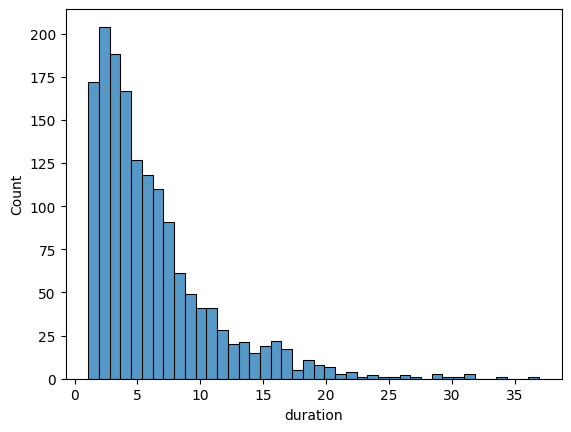

In [72]:
seaborn.histplot(chunks["duration"])

In [73]:
def folder_from_normalized_wav(original_audio, subfolder):
    folder = pathlib.Path(original_audio).parent.parent / subfolder / original_audio.stem
    return folder

In [74]:
def save_chunk(row):
    folder = folder_from_normalized_wav(row["normalized_wav"], "splits")
    folder.mkdir(exist_ok=True, parents=True)
    output_name = folder / f"{row['index']:04}.wav"
    row["sound"].export(output_name, format="wav")
    return output_name

In [75]:
chunks["index"] = chunks.groupby("normalized_wav", as_index=False).cumcount()

In [76]:
chunks.groupby("normalized_wav", as_index=False).apply(
    lambda x: shutil.rmtree(
        folder_from_normalized_wav(x["normalized_wav"].iloc[0], "splits")
    )
)

Empty DataFrame
Columns: []
Index: []

In [77]:
chunks["path"] = chunks.progress_apply(save_chunk, axis=1)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [80]:
chunks["sound"].iloc[151]

In [81]:
chunks["sound"].iloc[20]

# Denoise Files

In [82]:
chunks.groupby("normalized_wav", as_index=False).apply(
    lambda x: shutil.rmtree(
        folder_from_normalized_wav(x["normalized_wav"].iloc[0], "splits_denoised"),
        ignore_errors=True,
    )
)

Empty DataFrame
Columns: []
Index: []

In [83]:
def denoise(group):
    original_audio = group["normalized_wav"].iloc[0]
    input_folder = folder_from_normalized_wav(original_audio, "splits")
    output_folder = folder_from_normalized_wav(original_audio, "splits_denoised")
    command = f"speech_enhance_inference -I {input_folder} -O {output_folder} 2>&1 1>/dev/null"
    print(command)
    subprocess.check_call(command, shell=True)

In [84]:
chunks.groupby("normalized_wav", as_index=False).apply(denoise);

speech_enhance_inference -I /ssd500gb/archivio_barbero/splits/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014 -O /ssd500gb/archivio_barbero/splits_denoised/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014 2>&1 1>/dev/null
Inference:   0%|          | 0/587 [00:00<?, ?it/s]/home/user/src/FullSubNet-plus/speech_enhance/audio_zen/acoustics/feature.py:56: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:978.)
  return torch.istft(
Inference: 100%|██████████| 587/587 [00:59<00:00,  9.88it/s]
speech_enhance_inference -I /ssd500gb/archivio_barbero/splits/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2 -O /ssd500gb/archivio_barbero/splits_denoised/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2 2>&1 1>/dev/null
Inf

In [85]:
chunks["path_denoised"] = chunks["path"].replace("splits", "splits_denoised")

# Upload Files to S3

In [86]:
storage_client = boto3.client("s3")
response = storage_client.upload_file(data_local / vocabulary_file, bucket, str(vocabulary_file))

In [87]:
def upload(row, storage_client, bucket):
    object_name = f"splits_denoised/{pathlib.Path(row['normalized_wav']).stem}/{pathlib.Path(row['path_denoised']).name}"
    storage_client.upload_file(row["path_denoised"], bucket, object_name)
    return f"s3://{bucket}/{object_name}"

In [88]:
chunks["s3_uri"] = chunks.progress_apply(upload, axis=1, storage_client=storage_client, bucket=bucket)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [89]:
chunks.columns

Index(['normalized_wav', 'sound', 'duration', 'index', 'path', 'path_denoised',
       's3_uri'],
      dtype='object')

# Checkpoint to hard disk

In [90]:
chunks.to_pickle("/ssd500gb/archivio_barbero/notebook/chunks.pkl.gz")

# Create vocabulary

In [91]:
transcribe_client = boto3.client('transcribe')

In [92]:
words = pd.read_csv(data_local / vocabulary_file)
words["Phrases"] = words["Phrases"].str.replace(" ", "-")

In [93]:
transcribe_client.delete_vocabulary(VocabularyName=vocabulary_name)
time.sleep(15)
response = transcribe_client.create_vocabulary(
    LanguageCode='it-IT',
    VocabularyName=vocabulary_name,
    Phrases=words["Phrases"].tolist(),
)

In [94]:
while True:
    status = transcribe_client.get_vocabulary(VocabularyName=vocabulary_name)
    if status['VocabularyState'] in ['READY', 'FAILED']:
        break
    print("Not ready yet...")
    time.sleep(5)
print(status)

Not ready yet...
Not ready yet...
{'VocabularyName': 'barbero-guerre', 'LanguageCode': 'it-IT', 'VocabularyState': 'READY', 'LastModifiedTime': datetime.datetime(2023, 3, 18, 18, 54, 54, 56000, tzinfo=tzlocal()), 'DownloadUri': 'https://s3.eu-central-1.amazonaws.com/aws-transcribe-dictionary-model-eu-central-1-prod/180517682866/barbero-guerre/8c13f5d2-ef5c-49f3-9e6b-753e84a9331e/input.txt?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIH%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDGV1LWNlbnRyYWwtMSJGMEQCIFHaFZUq9MJAc5adSYpypo8aui4C2PjL64jSz1yARPXKAiBnliQNosIewLIf9rfj2DD0H7P%2FTL%2FjMG0NFOEgJNnlQCrFBQhKEAMaDDYwMjY1OTI4MTQ0NSIMbLJGq4qA%2Fw0NjRY%2FKqIFnc5VxgDTl4BsjHY8m%2Fi%2BTHQOvN%2FcYGxkPKBlf6ohc6CyVCLfzbetkak52OL08WbLvyCMIFViJVFcGOROKVDaswUpAsThkq7przt%2FPNQXaR%2Bf7FNG0taP8fCyJUVTZsAaaUQFvxR5b9BCG%2BKh3d0BN6%2Bh8Z3E7e7x%2Fj3Klo80qe3V3nTJgYhIfP5zlZ3DNyseH%2FByg9WPyil8b7bHN%2BCpmw2ZB6LsbmDVhwG6pkI%2BdpyH0IBTHj3VVkY93umXiSJ4FhlKvooB2aSVXvC5PoBFikkkrpvw8Sf6GrDYx%2BqPncmdWi6izvfYIz44vahUqbkE%2ByHqVyMFLGkju5owj

# Speech to Text: Transcribe

In [95]:
def speech_to_text(row, client):
    job_name = f'{row["path"].parent.name}-3-{row["path"].stem}'
    output_key = f"transcriptions/{job_name}.json"
    client.start_transcription_job(
        TranscriptionJobName=job_name,
        OutputBucketName=bucket,
        OutputKey=output_key,
        Media={'MediaFileUri': row["s3_uri"]},
        MediaFormat='wav',
        LanguageCode='it-IT',
        Settings={
            "VocabularyName": vocabulary_name,

        },
        JobExecutionSettings={
            "AllowDeferredExecution": True,
            "DataAccessRoleArn": "arn:aws:iam::180517682866:role/s3-role",
        },
    )
    return job_name

In [96]:
chunks["job_name"] = chunks.progress_apply(speech_to_text, axis=1, client=transcribe_client)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [97]:
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    def job_completed(job_name, transcribe_client):
        max_tries = 60
        while max_tries > 0:
            max_tries -= 1
            job = transcribe_client.get_transcription_job(TranscriptionJobName=job_name)
            job_status = job['TranscriptionJob']['TranscriptionJobStatus']
            if job_status in ['COMPLETED', 'FAILED']:
                if job_status == 'COMPLETED':
                    return job
            else:
                time.sleep(5)
    def job_completed_row(row, executor):
        return executor.submit(job_completed, job_name=row["job_name"], transcribe_client=transcribe_client)
    chunks["job_future"] = chunks.progress_apply(job_completed_row, axis=1, executor=executor)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [98]:
chunks["job"] = chunks["job_future"].progress_apply(lambda x: x.result())

  0%|          | 0/1567 [00:00<?, ?it/s]

In [99]:
def get_transcript_file_uri(job):
    if job is None:
        return None
    else:
        return job.get("TranscriptionJob", {}).get("Transcript", {}).get("TranscriptFileUri")

In [100]:
chunks["transcript_file_uri"] = chunks["job"].apply(get_transcript_file_uri)

# Extract the speech to text results

In [101]:
def download_transcript(row, bucket, storage_client):
    uri = row["transcript_file_uri"]
    key = uri.replace(f"https://s3.{region}.amazonaws.com/{bucket}/", "")
    o = storage_client.get_object(Bucket=bucket, Key=key)
    transcript = json.load(o["Body"])
    if transcript["status"] == "COMPLETED":
        result = pd.Series({
            "path_denoised": row["path_denoised"],
            "status": transcript["status"],
            "transcript": transcript["results"]["transcripts"][0]["transcript"]
        })
    else:
        result = pd.Series({
            "path_denoised": row["path_denoised"],
            "status": transcript["status"],
            "transcript": transcript["status"]
        })
    return result

In [102]:
transcribed = chunks[chunks["transcript_file_uri"].notnull()].progress_apply(
    download_transcript,
    axis=1,
    bucket=bucket,
    storage_client=storage_client,
)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [103]:
merged = pd.merge(chunks, transcribed, on="path_denoised")

In [104]:
merged.to_excel(data_local / "merged.xlsx", index=False)

In [105]:
def delete_job(row, transcribe_client):
    try:
        transcribe_client.delete_transcription_job(TranscriptionJobName=row["job_name"])
    except Exception:
        pass
    time.sleep(0.1)
_ = merged.progress_apply(delete_job, axis=1, transcribe_client=transcribe_client)

  0%|          | 0/1567 [00:00<?, ?it/s]

# Clean the transcriptions

In [109]:
cleaning = {
    "-": " ",
    "c' è": "c'è",
    "c', è": "c'è",
    "c'. è": "c'è",
    "\bé\b": "è",
    "gay": "gray",
    "\.$": "",
    "u'": "ù",
}

In [110]:
merged["clean_transcript"] = merged["transcript"].str.lower()
for key, value in cleaning.items():
    merged["clean_transcript"] = merged["clean_transcript"].str.replace(key, value, regex=True)

In [114]:
merged["clean_transcript"]

0                                come scoppiano le guerre
1       in realtà quello che vi racconterò io credo ch...
2       disastrosa, piena di sofferenza, piena di ince...
3       esempio nell'europa del da cui cominciamo stasera
4       come scoppia la prima guerra mondiale? beh, in...
                              ...                        
1562    quello che ha elettrizzato la gente era il fat...
1563    forse sarebbe stata più sincera. se avesse det...
1564    però ha avuto anche un modo di metterla che in...
1565    può far venire i brividi a qualcun altro. o ma...
1566    così come andare a rivedere in queste tre sera...
Name: clean_transcript, Length: 1567, dtype: object

In [115]:
merged.drop(columns=["job", "job_future"]).to_pickle("../data/merged.pkl.gz")

In [8]:
merged = pd.read_pickle("../data/merged.pkl.gz")

In [116]:
merged

normalized_wav  \
0     /ssd500gb/archivio_barbero/normalized_wav/7_La...   
1     /ssd500gb/archivio_barbero/normalized_wav/7_La...   
2     /ssd500gb/archivio_barbero/normalized_wav/7_La...   
3     /ssd500gb/archivio_barbero/normalized_wav/7_La...   
4     /ssd500gb/archivio_barbero/normalized_wav/7_La...   
...                                                 ...   
1562  /ssd500gb/archivio_barbero/normalized_wav/9_La...   
1563  /ssd500gb/archivio_barbero/normalized_wav/9_La...   
1564  /ssd500gb/archivio_barbero/normalized_wav/9_La...   
1565  /ssd500gb/archivio_barbero/normalized_wav/9_La...   
1566  /ssd500gb/archivio_barbero/normalized_wav/9_La...   

                                                  sound  duration  index  \
0     (((<pydub.audio_segment.AudioSegment object at...      1.43      0   
1     (((<pydub.audio_segment.AudioSegment object at...     15.67      1   
2     (((<pydub.audio_segment.AudioSegment object at...      8.61      2   
3     (((<pydub.audio_segment.AudioSegment object at...      4.20      3   
4     (((<pydub.audio_segment.AudioSegment object at...      5.84      4   
...                                                 ...       ...    ...   
1562  (((<pydub.audio_segment.AudioSegment object at...      9.50    455   
1563  (((<pydub.audio_segment.AudioSegment object at...      5.60    456   
1564  (((<pydub.audio_segment.AudioSegment object at...     15.11    457   
1565  (((<pydub.audio_segment.AudioSegment object at...      6.10    458   
1566  (((<pydub.audio_segment.AudioSegment object at...      7.74    459   

                                                   path  \
0     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
1     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
2     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
3     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
4     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
...                                                 ...   
1562  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1563  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1564  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1565  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1566  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   

                                          path_denoised  \
0     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
1     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
2     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
3     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
4     /ssd500gb/archivio_barbero/splits/7_La_Prima_G...   
...                                                 ...   
1562  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1563  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1564  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1565  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   
1566  /ssd500gb/archivio_barbero/splits/9_La_Guerra_...   

                                                 s3_uri  \
0     s3://barbero-tts2/splits_denoised/7_La_Prima_G...   
1     s3://barbero-tts2/splits_denoised/7_La_Prima_G...   
2     s3://barbero-tts2/splits_denoised/7_La_Prima_G...   
3     s3://barbero-tts2/splits_denoised/7_La_Prima_G...   
4     s3://barbero-tts2/splits_denoised/7_La_Prima_G...   
...                                                 ...   
1562  s3://barbero-tts2/splits_denoised/9_La_Guerra_...   
1563  s3://barbero-tts2/splits_denoised/9_La_Guerra_...   
1564  s3://barbero-tts2/splits_denoised/9_La_Guerra_...   
1565  s3://barbero-tts2/splits_denoised/9_La_Guerra_...   
1566  s3://barbero-tts2/splits_denoised/9_La_Guerra_...   

                                               job_name  \
0     7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   
1     7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   
2     7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   
3     7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_... 

# Analyze SNR

In [117]:
merged["snr"] = merged["sound"].apply(wada_snr)

<Axes: xlabel='snr', ylabel='Count'>

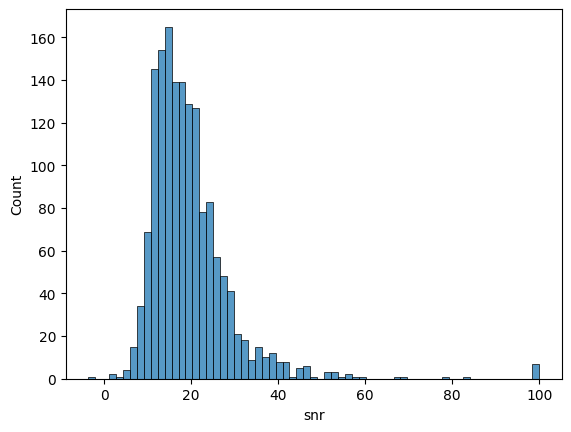

In [118]:
seaborn.histplot(merged["snr"])

In [119]:
sorted_snr = merged.sort_values("snr")

In [126]:
sorted_snr.iloc[10]["sound"]

# Fine tune audio configuration

In [127]:
generic_configuration = load_config(config_path)
tune_params={
    # 'num_mels': 80,          # In general, you don't need to change this. 
    # 'fft_size': 1024,        # In general, you don't need to change this.
    # 'hop_length': 256,       # In general, you don't need to change this.
    # 'win_length': 1024,      # In general, you don't need to change this.
    'preemphasis': 0.99,     # In general, 0 gives better voice recovery but makes training harder. If your model does not train, try 0.97 - 0.99.
    'min_level_db': -100,
    'ref_level_db': -10,       # The base DB; increase until all background noise is removed in the spectrogram, then lower until you hear better speech below.   
    'power': 1.5,            # Change this value and listen to the synthesized voice. 1.2 - 1.5 are resonable values.
    'griffin_lim_iters': 60, # Quality does not improve for values > 60
    'mel_fmin': 0.0,         # Adjust this and check mel-spectrogram-based voice synthesis below.
    'mel_fmax': 4000.0,      # Adjust this and check mel-spectrogram-based voice synthesis below.
    # 'do_trim_silence': True  # If you dataset has some silience at the beginning or end, this trims it. Check the AP.load_wav() below,if it causes any difference for the loaded audio file.
}

# Override select parts of loaded config with parameters above
tuned_config = dict(generic_configuration.audio.copy())
tuned_config.update(tune_params)
audio_processor = AudioProcessor(**tuned_config);
test_audio_path = merged["path_denoised"].iloc[1000]
test_audio = audio_processor.load_wav(test_audio_path)
IPython.display.Audio(data=test_audio, rate=frame_rate)

 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:-10
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.99
 | > griffin_lim_iters:60
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:4000.0
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024


In [128]:
def compare_values(file, config, attribute, values):
    """
    attributes (str): the names of the attribute you like to test.
    values (list): list of values to compare.
    """
    audio_processor = AudioProcessor(**config);
    figure = plt.figure(figsize=(20.0, 16.0))
    wavs = []
    for idx, val in enumerate(values):
        setattr(audio_processor, attribute, val)
        wav = audio_processor.load_wav(file)
        spec = audio_processor.spectrogram(wav)
        spec_norm = audio_processor.denormalize(spec.T)
        plt.subplot(len(values), 2, 2*idx + 1)
        plt.imshow(spec_norm.T, aspect="auto", origin="lower")
        #         plt.colorbar()
        plt.tight_layout()
        wav_gen = audio_processor.inv_spectrogram(spec)
        wavs.append(wav_gen)
        plt.subplot(len(values), 2, 2*idx + 2)
        display.waveplot(wav, alpha=0.5, color="blue")
        display.waveplot(wav_gen, alpha=0.25, color="green")
        plt.title("{}={}".format(attribute, val))
        plt.tight_layout()
    
    wav = audio_processor.load_wav(file)
    print(" > Ground-truth")
    IPython.display.display(IPython.display.Audio(wav, rate=audio_processor.sample_rate))
    
    for idx, wav_gen in enumerate(wavs):
        val = values[idx]
        print(" > {} = {}".format(attribute, val))
        IPython.display.display(IPython.display.Audio(wav_gen, rate=audio_processor.sample_rate))
    return figure

 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:-10
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.99
 | > griffin_lim_iters:60
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:4000.0
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Ground-truth


 > preemphasis = 0


 > preemphasis = 0.5


 > preemphasis = 0.99


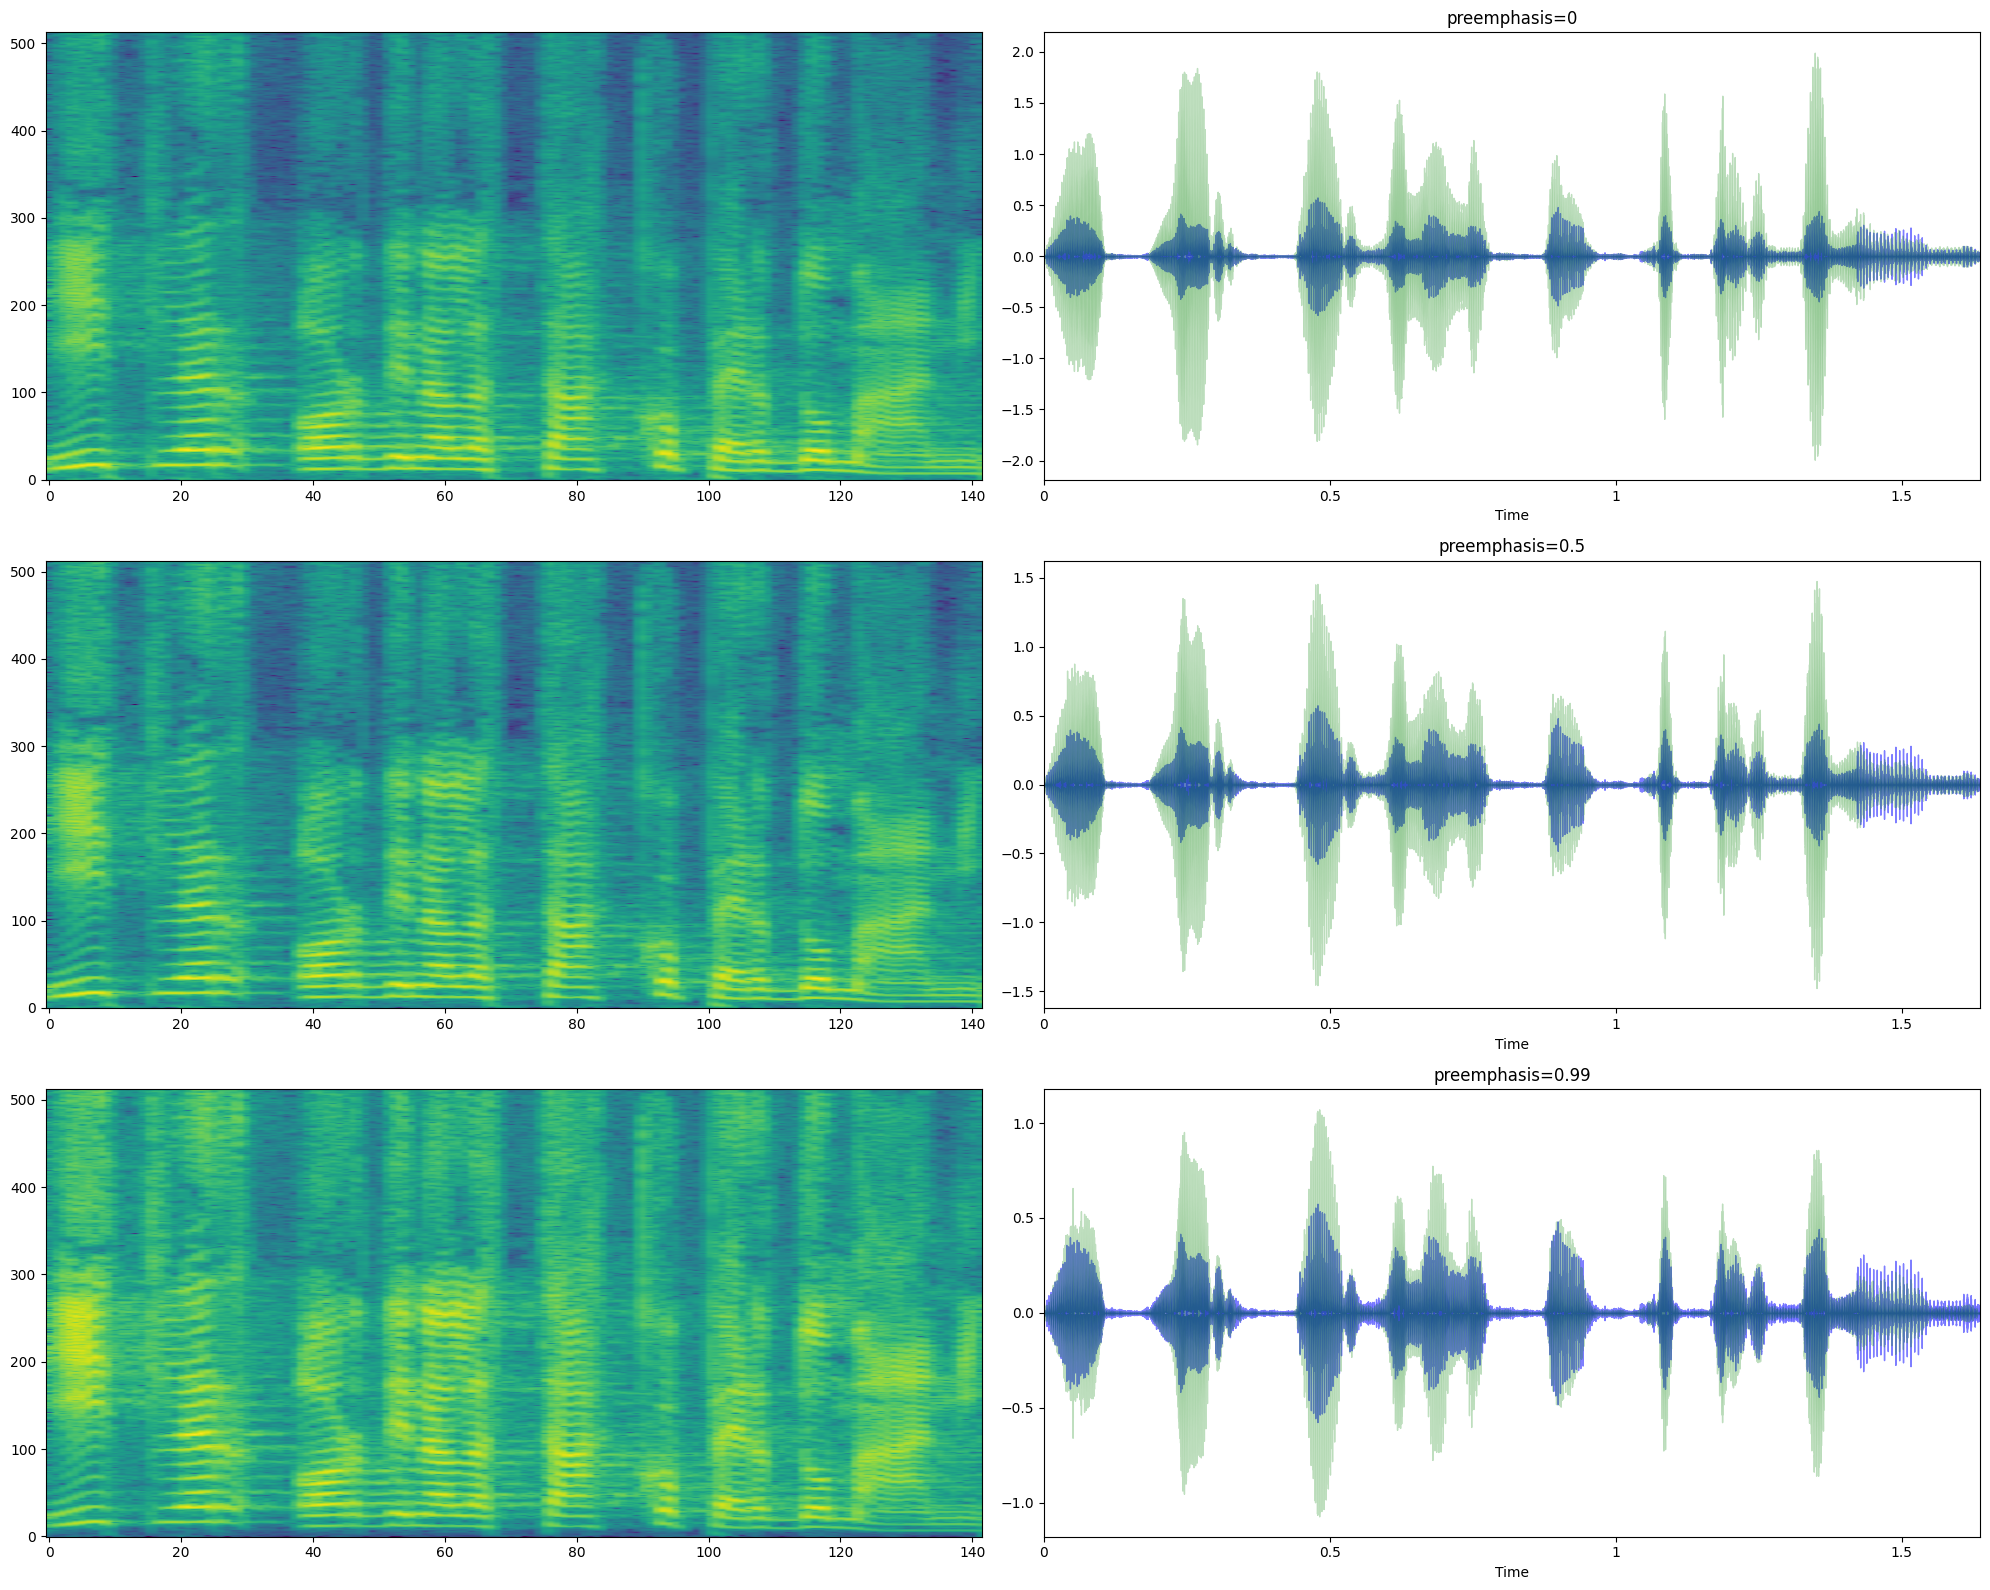

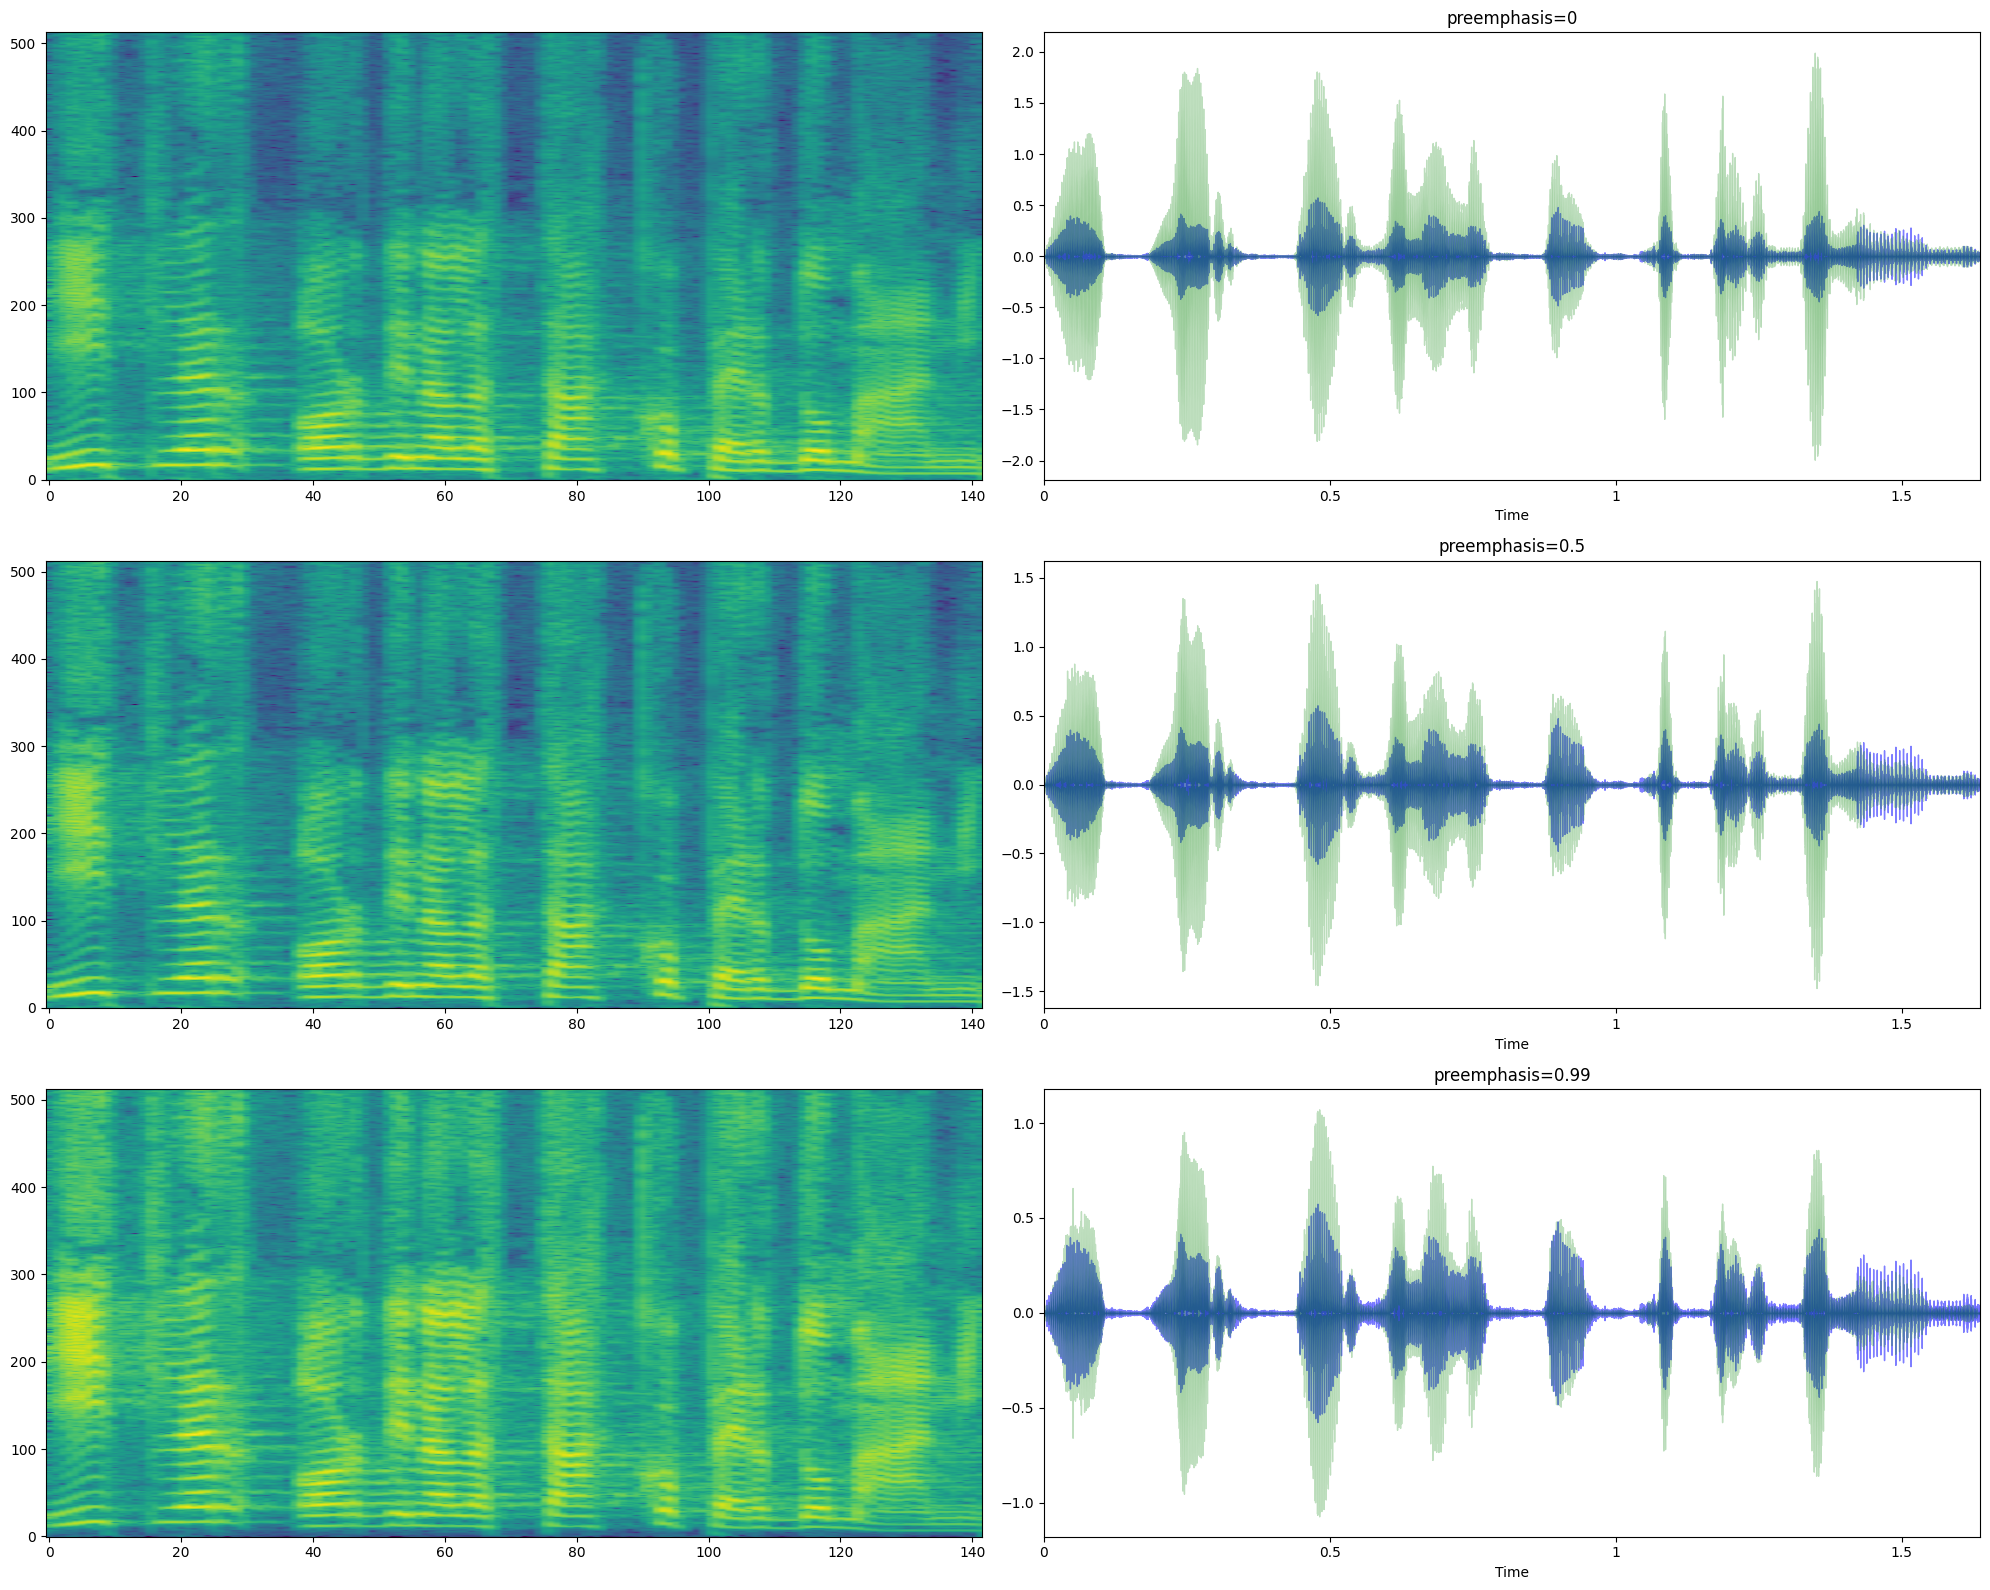

In [129]:
compare_values(test_audio_path, tuned_config, "preemphasis", [0, 0.5, 0.99])

# Write files to SSD and prepare metadata file

In [131]:
merged["audio_file"] = merged["path_denoised"]

In [144]:
final_filter = (
    (merged["snr"] > 15)
    & (merged["duration"] < 25)
    & (merged["clean_transcript"].str.len() > 0)
)

final = merged.loc[final_filter, ["audio_file", "clean_transcript"]].rename(
    columns={"clean_transcript": "text"}
)
final["audio_file"] = final["audio_file"].apply(lambda x: pathlib.Path(x).relative_to(pathlib.Path(x).parent.parent))

In [145]:
final.to_csv("../data/audio_metadata.csv", index=False, sep="|")

In [146]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 1 to 1566
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   audio_file  1022 non-null   object
 1   text        1022 non-null   object
dtypes: object(2)
memory usage: 24.0+ KB


In [147]:
final.head()

audio_file  \
1  7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   
2  7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   
3  7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   
4  7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   
5  7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...   

                                                text  
1  in realtà quello che vi racconterò io credo ch...  
2  disastrosa, piena di sofferenza, piena di ince...  
3  esempio nell'europa del da cui cominciamo stasera  
4  come scoppia la prima guerra mondiale? beh, in...  
5                                      il giugno del

# Total duration of the clean transcripts

In [149]:
total_duration = pd.Timedelta(seconds=merged.loc[final_filter]["duration"].sum())
total_duration

Timedelta('0 days 02:07:38.200000')